# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

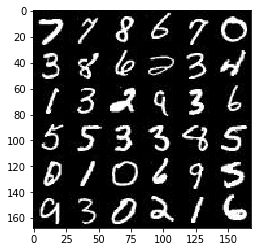

In [14]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

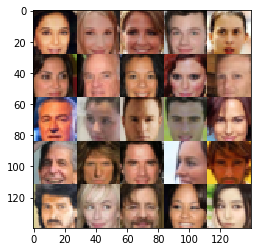

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return (input, z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [75]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha = 0.2
        
        # Input layer is 28x28x3/1
        x1 = tf.contrib.layers.conv2d(images, 64, 5, stride=2, padding='same')
        relu1 = tf.maximum(x1 * alpha, x1) 
            
        # 2nd conv layer is 14x14x128
        x2 = tf.contrib.layers.conv2d(relu1, 128, 5, stride=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        
        # 3rd conv layer is 7x7x256
        x3 = tf.contrib.layers.conv2d(relu2, 256, 5, stride=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)

        # Flatten the tensor 4x4x256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        
        # Fully connectd layer with Xavier initialiser for weights
        logits = tf.contrib.layers.fully_connected(flat, 1, activation_fn=None)
        logits = tf.layers.dropout(logits, rate=0.75, training=True)
        
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [76]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        alpha = 0.2

        x1 = tf.contrib.layers.fully_connected(z, 4*4*512) #, activation_fn=None)
        x1 = tf.layers.dropout(x1, rate=0.75, training=is_train)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, momentum=0.5, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        
        x2 = tf.contrib.layers.conv2d_transpose(x1, 256, 4, stride=1, padding='valid', activation_fn=None)
        x2 = tf.layers.batch_normalization(x2, momentum=0.5, training=is_train)
        x2 = tf.maximum(x2 * alpha, x2)
        
        x3 = tf.contrib.layers.conv2d_transpose(x2, 128, 5, stride=2, padding='same', activation_fn=None)
        x3 = tf.layers.batch_normalization(x3, momentum=0.5, training=is_train)
        x3 = tf.maximum(x3 * alpha, x3)
        
        logits = tf.contrib.layers.conv2d_transpose(x3, out_channel_dim, 5, stride=2, padding='same', activation_fn=None)       
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [77]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Smoothing 
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean( \
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
                                                                         labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean( \
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
                                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
                                                        labels=tf.ones_like(d_logits_fake)))
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [78]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [79]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [80]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step = 0
    print_every = 100
    
    #tf.reset_default_graph()
    
    input_real, input_z, t_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print("data shape", data_shape[-3:])
    #saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Sample random noise for G
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))

                # Run optimizers
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, t_learning_rate: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, t_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, t_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, t_learning_rate: learning_rate})
                
                step += 1                
                if step % print_every == 0:
                    show_generator_output(sess, 25, input_z, len(data_image_mode), data_image_mode)
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
            print("################ END OF EPOCH ##################")
        print("################ END OF SESSION ##################")


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data shape (28, 28, 1)


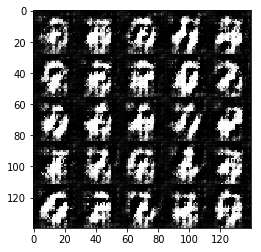

Epoch 1/2... Discriminator Loss: 1.5207... Generator Loss: 4.0520


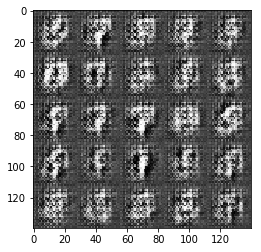

Epoch 1/2... Discriminator Loss: 1.9368... Generator Loss: 2.4465


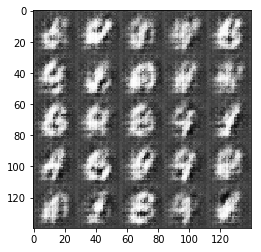

Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 3.8792


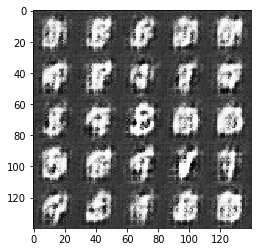

Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 2.3407


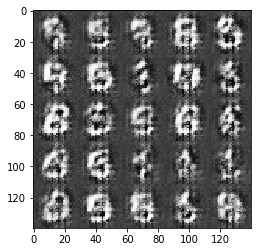

Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 1.9423


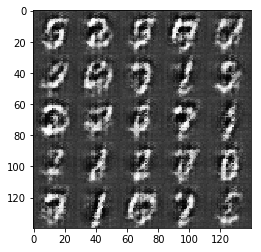

Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 1.1269


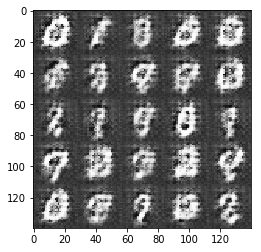

Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 1.2929


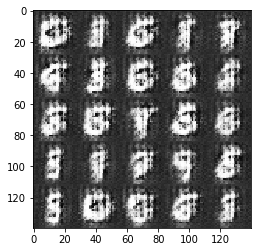

Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 2.2127


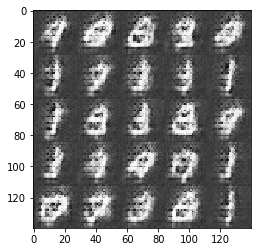

Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 2.0027


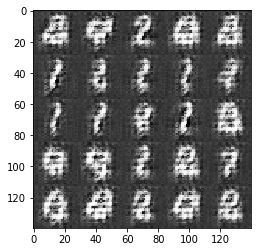

Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.9656


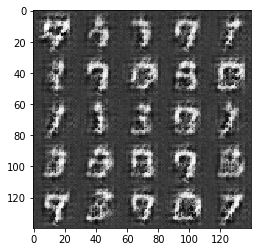

Epoch 1/2... Discriminator Loss: 1.5484... Generator Loss: 1.6205


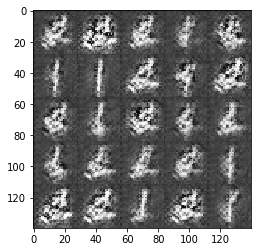

Epoch 1/2... Discriminator Loss: 1.0306... Generator Loss: 2.1105


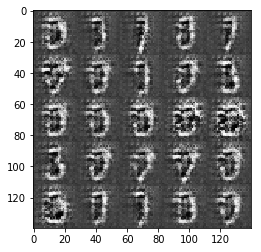

Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 1.8304


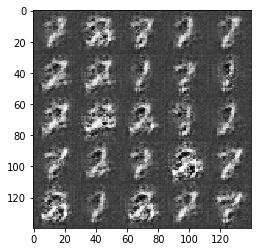

Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 1.4698


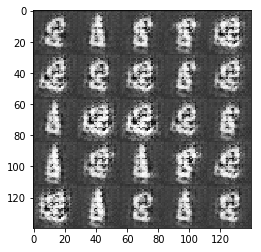

Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 1.9273


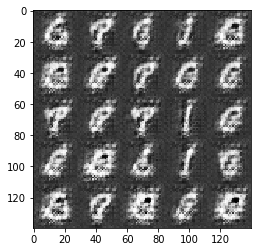

Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 1.3274


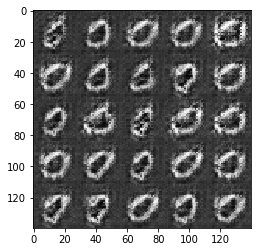

Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 1.4644


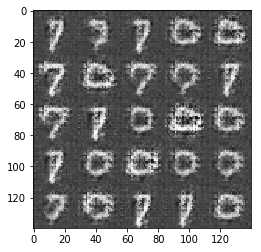

Epoch 1/2... Discriminator Loss: 1.7221... Generator Loss: 3.6923
################ END OF EPOCH ##################


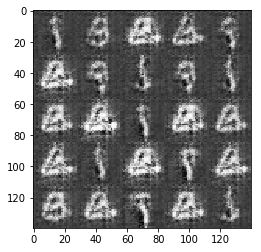

Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 2.0039


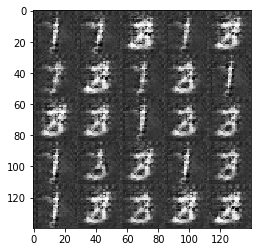

Epoch 2/2... Discriminator Loss: 1.1659... Generator Loss: 1.4755


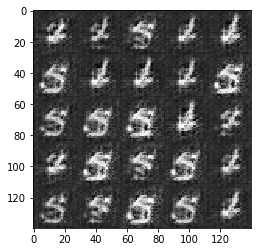

Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 1.3406


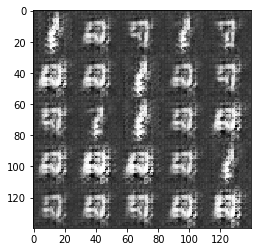

Epoch 2/2... Discriminator Loss: 1.0943... Generator Loss: 1.3852


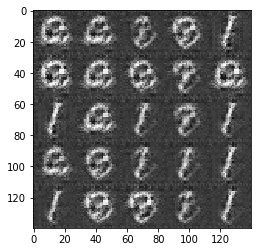

Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 1.6608


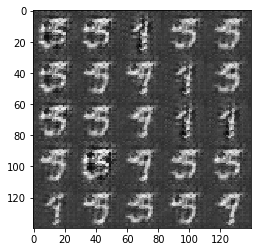

Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 1.1867


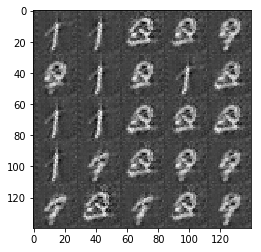

Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 2.7537


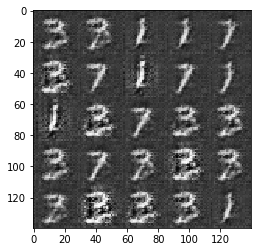

Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 1.2625


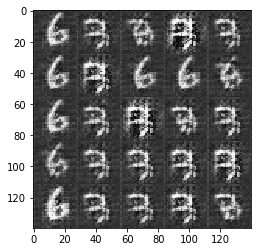

Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 4.6159


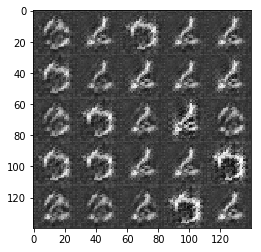

Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 0.8584


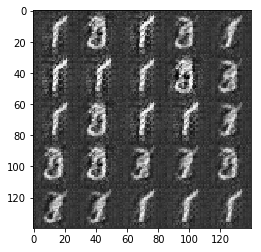

Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 1.6056


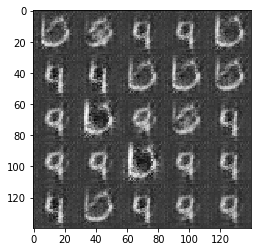

Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 2.0139


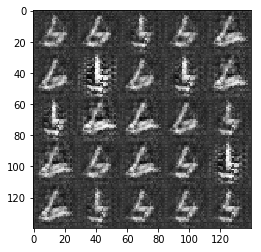

Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 1.1725


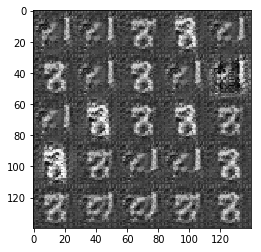

Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 2.7640


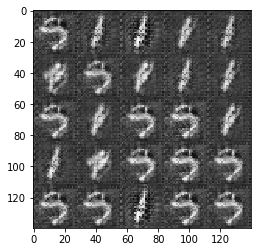

Epoch 2/2... Discriminator Loss: 1.2232... Generator Loss: 0.7473


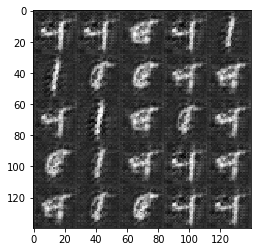

Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.9220


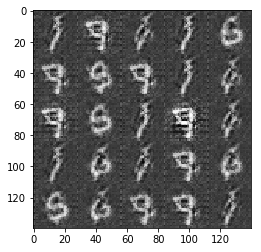

Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 1.4173


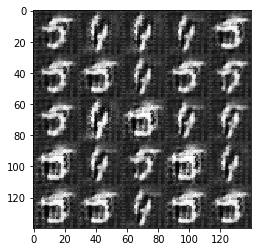

Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 1.9718


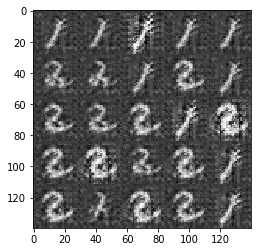

Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 1.1109
################ END OF EPOCH ##################
################ END OF SESSION ##################


In [81]:
batch_size = 32 #None
z_dim = 100 #None
learning_rate = 0.0004 #None
beta1 = 0.5 #None

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data shape (28, 28, 3)


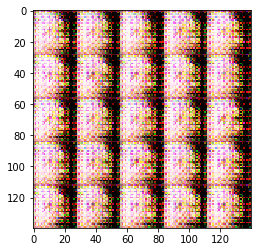

Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 7.0068


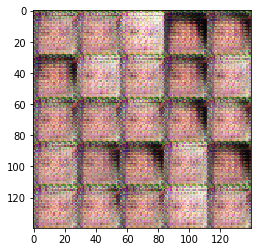

Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 2.5565


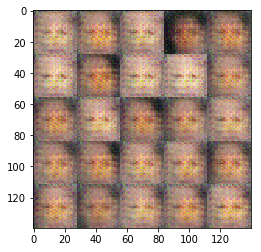

Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 1.2809


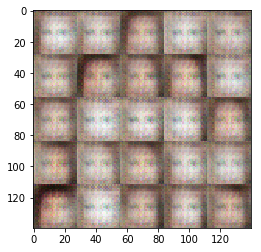

Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.8643


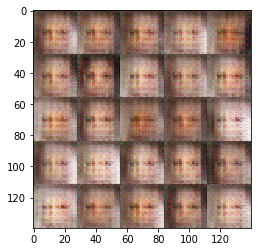

Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 1.0013


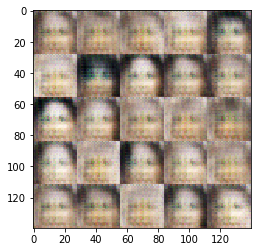

Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 1.2395


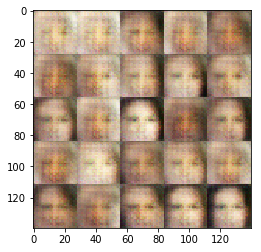

Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 1.2349


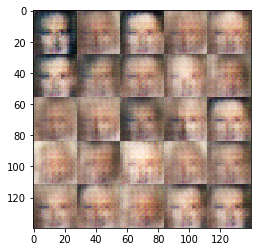

Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 1.1965


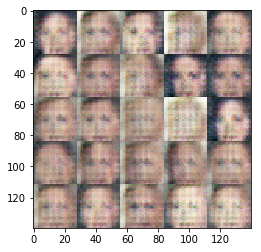

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8495


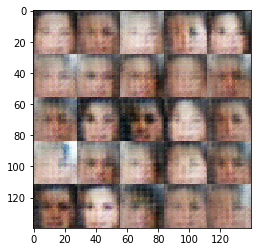

Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8867


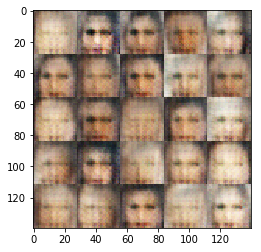

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 1.2453


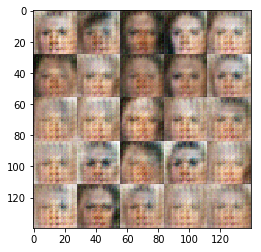

Epoch 1/1... Discriminator Loss: 2.2388... Generator Loss: 1.6881


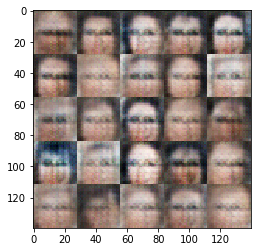

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 1.9990


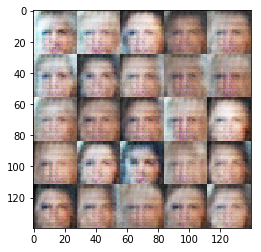

Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6234


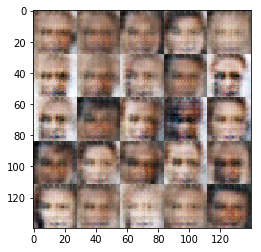

Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.0081


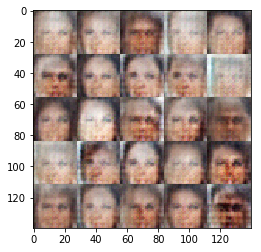

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.1369


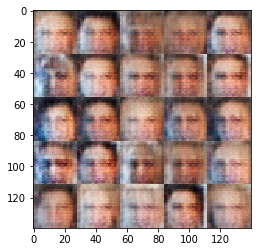

Epoch 1/1... Discriminator Loss: 1.6453... Generator Loss: 1.1677


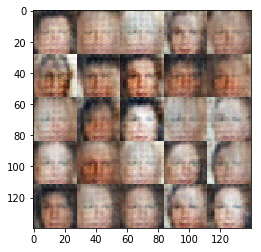

Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8560


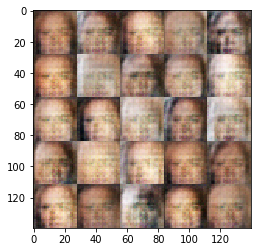

Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.9132


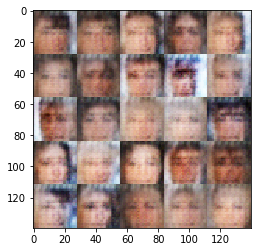

Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 1.3114


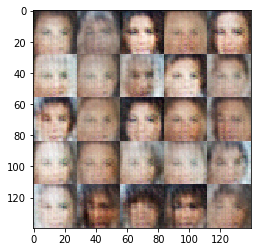

Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8458


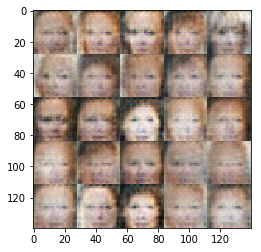

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 1.4333


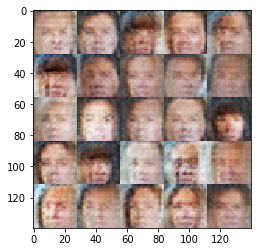

Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7153


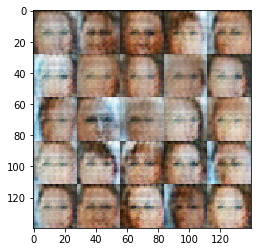

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.0910


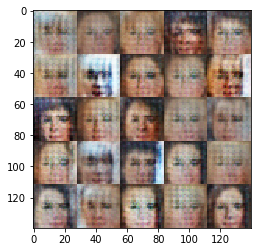

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.9268


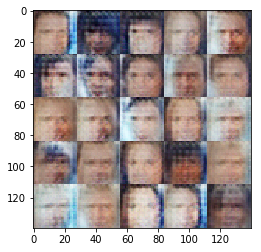

Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7571


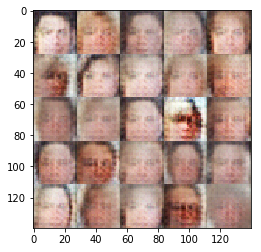

Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.8488


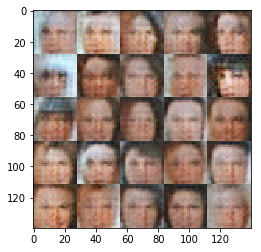

Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 1.0499


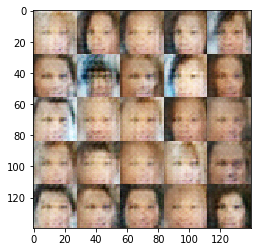

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.9940


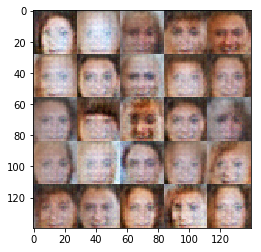

Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7250


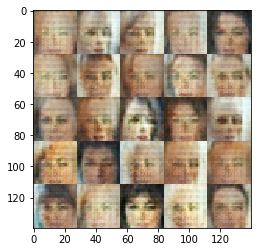

Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9509


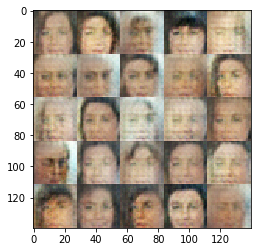

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6211


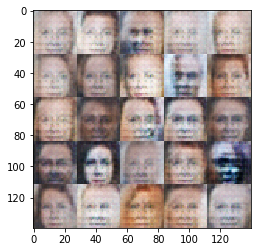

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.7133


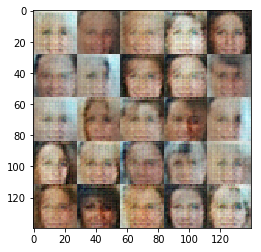

Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.8803


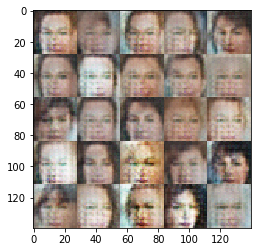

Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 1.1538


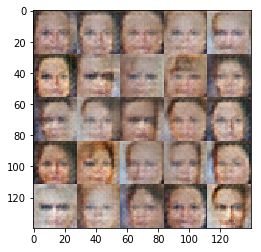

Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6472


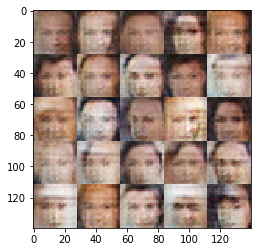

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7174


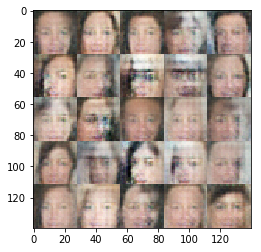

Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9663


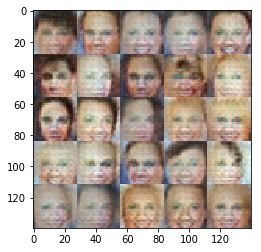

Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 1.2663


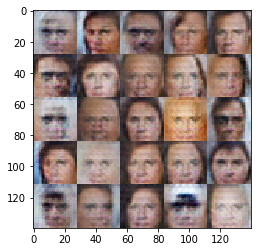

Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7204


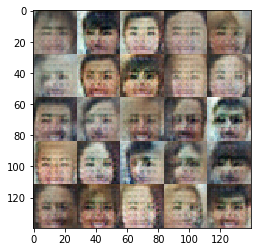

Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8985


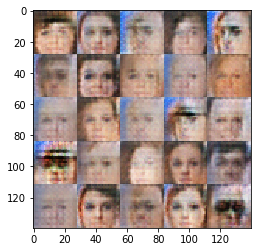

Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.7696


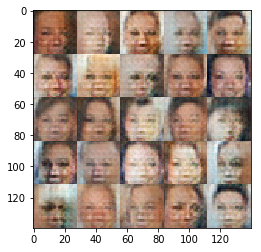

Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 1.0528


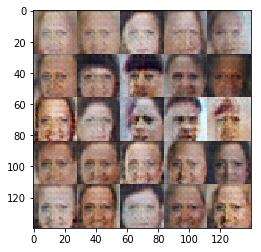

Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.7364


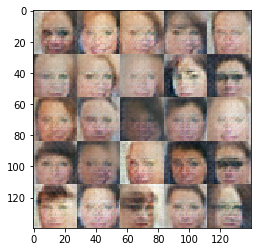

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8050


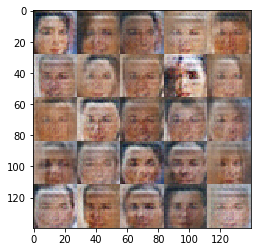

Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7944


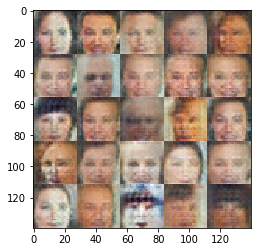

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8158


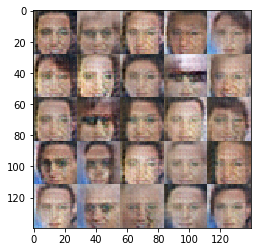

Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.7660


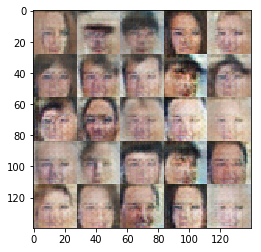

Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8267


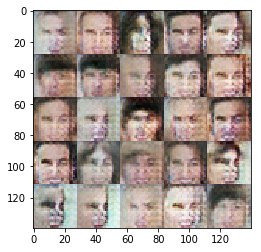

Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.9143


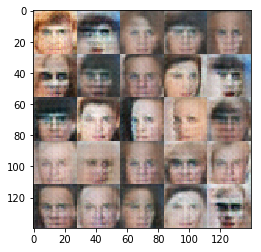

Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.4581


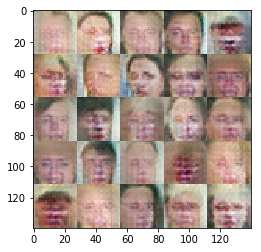

Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 1.1351


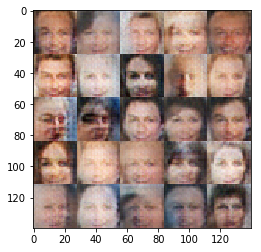

Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7968


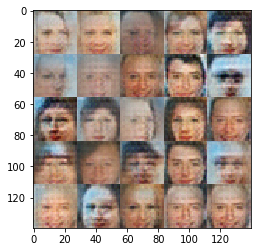

Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 1.4055


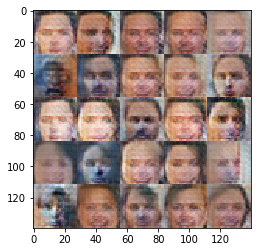

Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7028


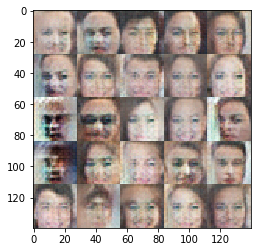

Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.2012


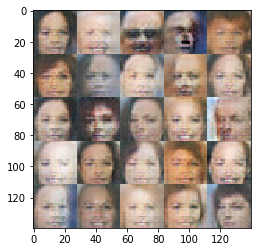

Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7160


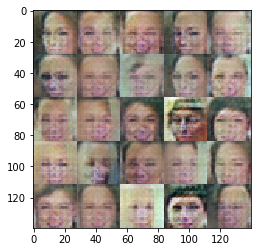

Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.9105


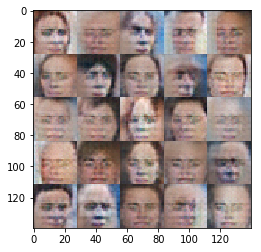

Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9599


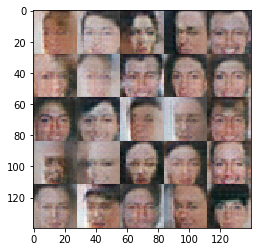

Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7264


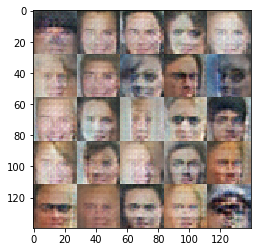

Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8571


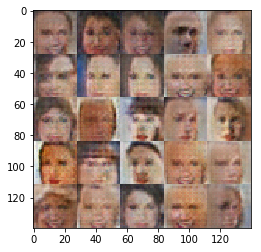

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 1.3880
################ END OF EPOCH ##################
################ END OF SESSION ##################


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.